<a href="https://colab.research.google.com/github/awina1077/majeg-api/blob/main/Tutorial%20Skripsi%20Coconut%20Majeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pelatihan Model YOLO di Google Colab

Penulis: I Dewa Gede Agung Wibhisana Natih
Terakhir diperbarui: Oktober 2025

Pendahuluan

Bagian ini menjelaskan proses pelatihan model YOLO (You Only Look Once) menggunakan Google Colaboratory (Google Colab) untuk mendeteksi dan mengestimasi jumlah buah kelapa pada pohon. Proses pelatihan dilakukan dengan memanfaatkan framework Ultralytics, yang mendukung berbagai versi YOLO seperti YOLOv5, YOLOv8, hingga YOLOv11.
Melalui proses ini, dihasilkan model deteksi objek yang telah dilatih menggunakan dataset kelapa sehingga dapat digunakan untuk sistem deteksi berbasis web.

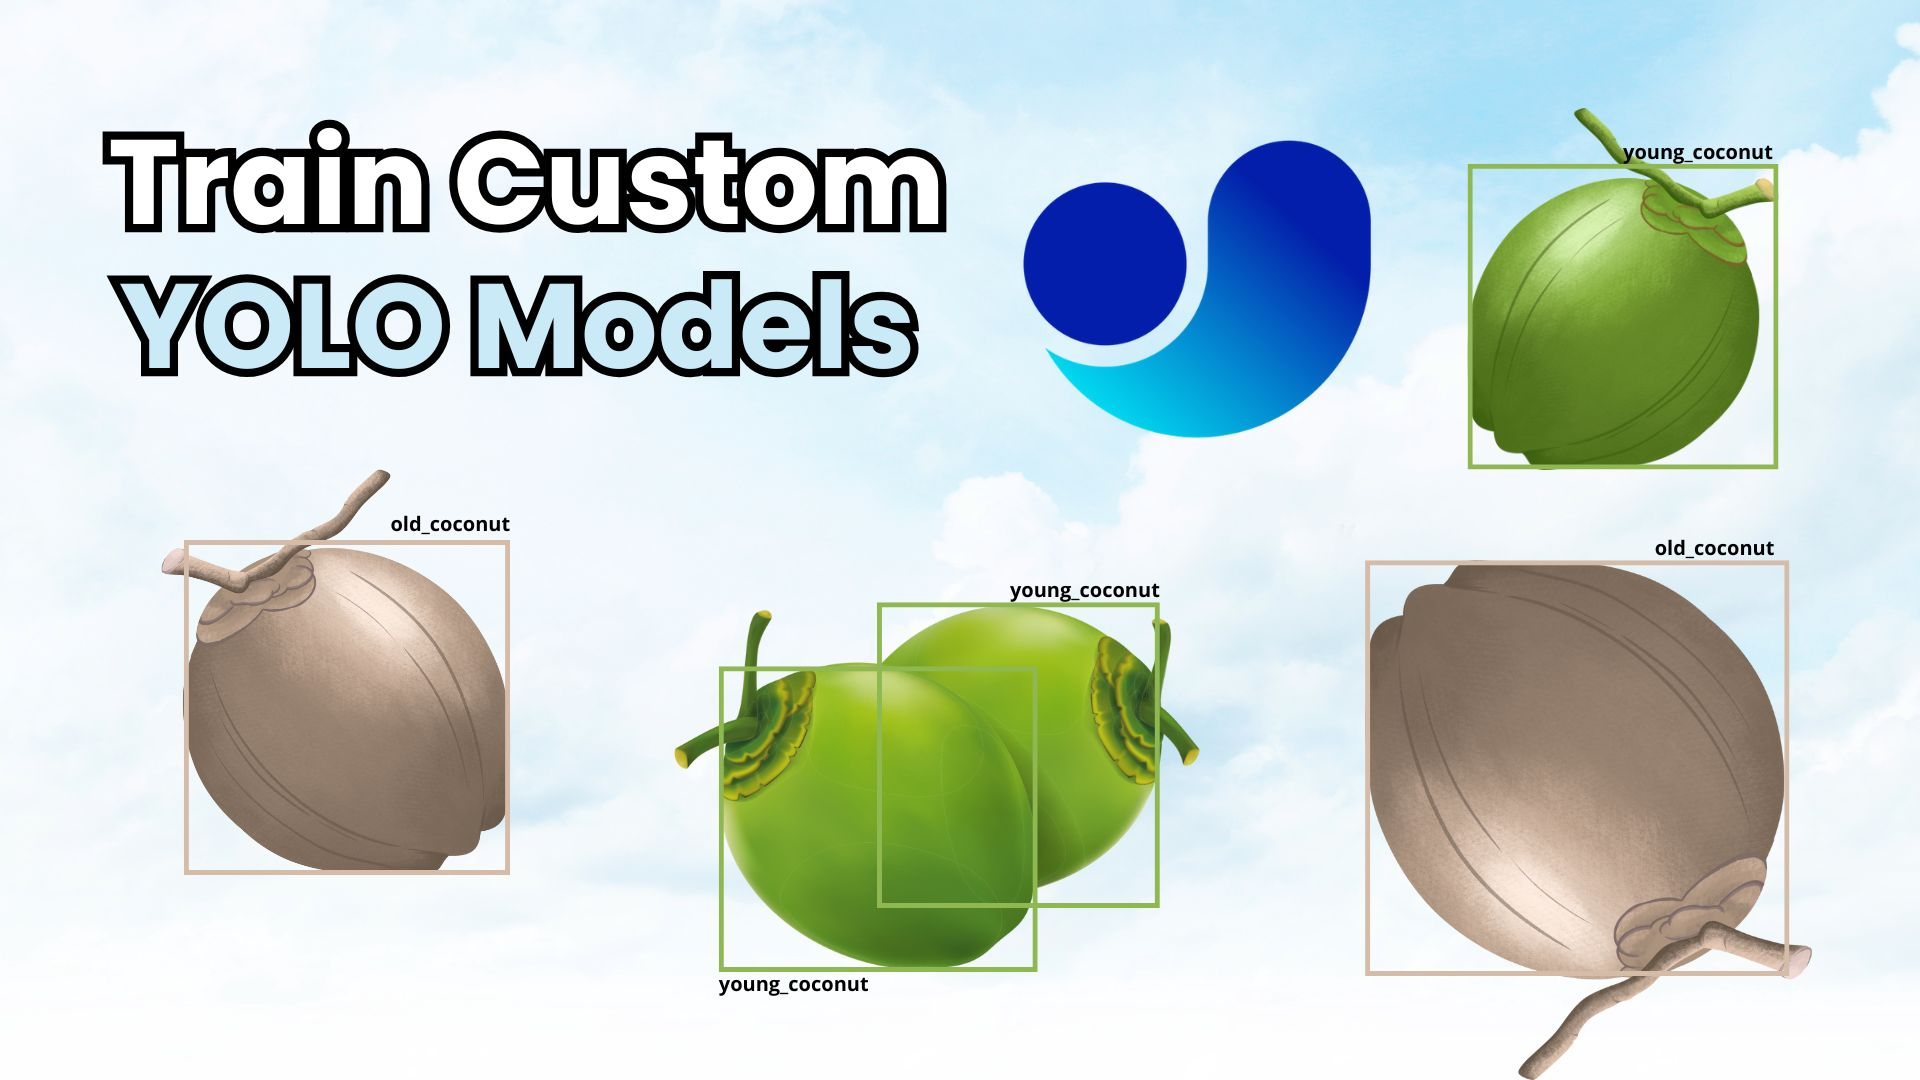
Deskripsi Platform

Google Colab merupakan layanan berbasis cloud yang menyediakan lingkungan pemrograman Python lengkap dengan sistem operasi Linux, penyimpanan virtual, serta dukungan GPU secara gratis. Colab digunakan dalam penelitian ini untuk melatih model YOLO dengan dataset kustom karena kemudahan akses, kemampuan komputasi yang tinggi, dan kemampuannya dalam menjalankan framework deep learning seperti PyTorch dan Ultralytics.

**Verify NVIDIA GPU Availability**

Make sure you're using a GPU-equipped machine by going to "Runtime" -> "Change runtime type" in the top menu bar, and then selecting one of the GPU options in the Hardware accelerator section. Click Play on the following code block to verify that the NVIDIA GPU is present and ready for training.

In [ ]:
!nvidia-smi

Mon Oct  6 15:41:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   60C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 1.&nbsp;Upload Image Dataset and Prepare Training Data

Next, we'll upload our dataset and prepare it for training with YOLO. We'll split the dataset into train and validation folders, and we'll automatically generate the configuration file for training the model.

## 1.1 Upload images

Pertama, kita perlukan untuk upload dataset ke Collab. Ini adalah bagaimana cara setup `data.zip` ke folder di collab.

**Option 1. Upload through Google Colab**

Unggah `data.zip` file ke Collab dengan click "Files" icon ada di sebelah kanan dibawah tulisan "Files", setelah itu "Upload to session storage" icon. Pilih zip folder di local lalu unggah
<p>
<br>
<img src="https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/doc/upload-colab-files.png" height="240">
</p>



Anda juga dapat mengunggah dataset gambar ke Google Drive pribadi, kemudian memasang (mount) Drive tersebut pada sesi Google Colab, dan menyalin data ke dalam sistem file Colab.
Opsi ini sangat cocok digunakan jika Anda ingin mengunggah data sebelumnya agar tidak perlu menunggu proses unggahan setiap kali Colab dijalankan ulang. Jika ukuran dataset Anda lebih dari 50 MB, disarankan menggunakan cara ini.

Langkah-langkahnya sebagai berikut:

1. Unggah file data.zip ke Google Drive Anda.

2. Catat lokasi folder tempat Anda mengunggah file tersebut.

3. Ganti path MyDrive/path/to/data.zip dengan lokasi sebenarnya dari file di Drive Anda.
(Sebagai contoh, jika file diunggah ke folder bernama coconut-dataset, maka path-nya adalah MyDrive/coconut-dataset/data.zip.)

4. Jalankan blok kode berikut di Google Colab untuk memasang (mount) Google Drive dan menyalin folder tersebut ke sistem file Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp /content/gdrive/MyDrive/path/to/data.zip /content

Mounted at /content/gdrive


## 2.2 Split images into train and validation folders

Pada tahap ini, baik Anda menggunakan Opsi 1 maupun Opsi 2, Anda seharusnya sudah dapat mengklik ikon folder di sisi kiri dan melihat file `data.zip` di daftar file.

Selanjutnya, kita akan mengekstrak (unzip) file `data.zip` tersebut dan membuat beberapa folder untuk menyimpan gambar. Jalankan blok kode berikut untuk mengekstrak data.

In [ ]:
# Unzip gambar ke custom_data folder
!unzip -q /content/data.zip -d /content/custom_data

Ultralytics memerlukan **struktur folder tertentu** untuk menyimpan data pelatihan model. Folder utama biasanya diberi nama **“data”**. Di dalamnya terdapat tiga folder utama, yaitu:

* **Train**: berisi kumpulan gambar yang digunakan untuk **melatih model (training)**.
  Pada setiap *epoch* pelatihan, seluruh gambar dalam folder *train* akan diproses oleh jaringan saraf (neural network). Algoritma pelatihan akan menyesuaikan bobot (*weights*) jaringan agar sesuai dengan pola data pada gambar-gambar tersebut.

* **Validation**: berisi gambar-gambar yang digunakan untuk **memvalidasi kinerja model** di setiap akhir *epoch*.
  Dataset ini tidak digunakan untuk memperbarui bobot model, melainkan untuk mengevaluasi apakah model mampu melakukan generalisasi dengan baik terhadap data yang tidak digunakan dalam pelatihan.

* **Test**: berisi gambar-gambar yang digunakan untuk **mengukur performa akhir model** setelah pelatihan selesai.
  Dataset ini sepenuhnya terpisah dari data pelatihan dan validasi, sehingga hasil pengujian dapat menunjukkan kemampuan model terhadap data baru yang belum pernah dilihat sebelumnya.

Di dalam masing-masing folder tersebut terdapat dua subfolder utama:

* **images** → menyimpan file gambar.
* **labels** → menyimpan file anotasi (label) yang berisi informasi posisi dan kelas objek pada gambar.


# 3.&nbsp;Install Requirements (Ultralytics)

Selanjutnya, kita akan menginstal pustaka Ultralytics pada sesi Google Colab ini.
Pustaka Python ini akan digunakan untuk melatih model YOLO (You Only Look Once) pada dataset yang telah disiapkan.

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.2 MB/s eta 0:00:00


# 4.&nbsp;Configure Training


Ada satu langkah terakhir sebelum proses pelatihan dapat dijalankan, yaitu membuat file konfigurasi YAML untuk pelatihan Ultralytics.
File ini berfungsi untuk menentukan lokasi data train, validation, dan testing serta mendefinisikan kelas objek (classes) yang akan dikenali oleh model.

Jalankan blok kode di bawah ini untuk membuat file konfigurasi data.yaml secara otomatis.
Pastikan Anda sudah memiliki file classes.txt yang terletak di direktori custom_data/classes.txt.

In [ ]:
# Fungsi Python untuk membuat file konfigurasi data.yaml secara otomatis
# 1. Membaca file "classes.txt" untuk mendapatkan daftar nama kelas
# 2. Membuat struktur data dictionary yang berisi lokasi folder, jumlah kelas, dan nama kelas
# 3. Menulis data tersebut ke dalam format YAML dan menyimpannya sebagai data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Membaca file classes.txt untuk mendapatkan daftar nama kelas
  if not os.path.exists(path_to_classes_txt):
    print(f'File classes.txt tidak ditemukan! Silakan buat file classes.txt dan letakkan di {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue  # Lewati baris kosong
      classes.append(line.strip())          # Tambahkan setiap nama kelas ke dalam list
  number_of_classes = len(classes)

  # Membuat struktur data dictionary untuk konfigurasi pelatihan YOLO
  data = {
      'path': '/content/custom_data',   # Lokasi direktori utama dataset
      'train': 'train/images',          # Lokasi folder gambar untuk data training
      'val': 'valid/images',            # Lokasi folder gambar untuk data validasi
      'test': 'test/images',            # Lokasi folder gambar untuk data pengujian
      'nc': number_of_classes,          # Jumlah kelas yang akan dideteksi
      'names': classes                  # Daftar nama kelas
  }

  # Menulis data konfigurasi ke dalam file YAML
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'File konfigurasi berhasil dibuat di {path_to_data_yaml}')

  return

# Menentukan lokasi file classes.txt dan data.yaml, lalu menjalankan fungsi
path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/custom_data/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nIsi file data.yaml:\n')
!cat /content/data.yaml

Created config file at /content/custom_data/data.yaml

File contents:

cat: /content/data.yaml: No such file or directory


# 5.&nbsp;Train Model

## 5.1 Parameter Pelatihan

Setelah data tersusun dengan benar dan file konfigurasi telah dibuat, langkah selanjutnya adalah **memulai proses pelatihan model YOLO**.
Sebelum menjalankan pelatihan, terdapat beberapa parameter penting yang perlu ditentukan terlebih dahulu.

---

### **Arsitektur dan Ukuran Model (`model`)**

Ultralytics menyediakan beberapa varian ukuran model YOLO11 yang dapat digunakan untuk pelatihan, yaitu:
`yolo11n.pt`, `yolo11s.pt`, `yolo11m.pt`.

Setiap varian memiliki perbedaan pada kecepatan dan tingkat akurasi:

* Model **lebih kecil** (misalnya `yolo11n.pt` atau `yolo11s.pt`) memiliki **kecepatan lebih tinggi**, namun akurasinya cenderung lebih rendah.

Apabila belum yakin model mana yang paling sesuai, varian **`yolo11s.pt`** merupakan pilihan awal yang seimbang antara kecepatan dan akurasi.

---

### **Jumlah Epoch (`epochs`)**

Dalam pembelajaran mesin, satu *epoch* berarti satu kali perulangan penuh terhadap seluruh dataset pelatihan.
Parameter `epochs` menentukan berapa lama model akan dilatih. Nilai yang ideal tergantung pada **ukuran dataset** dan **kompleksitas model**.

Jumlah *epoch* yang terlalu sedikit dapat menyebabkan model belum belajar dengan baik (*underfitting*), sedangkan jumlah yang terlalu banyak dapat menyebabkan model terlalu menyesuaikan data pelatihan (*overfitting*).

---

### **Resolusi Gambar (`imgsz`)**

Resolusi memiliki pengaruh besar terhadap **kecepatan** dan **akurasi** model.

* Resolusi yang **lebih rendah** membuat proses pelatihan dan inferensi menjadi **lebih cepat**, tetapi akurasi bisa menurun.
* Resolusi yang **lebih tinggi** dapat meningkatkan akurasi, namun memerlukan waktu pelatihan dan daya komputasi yang lebih besar.

Secara umum, model YOLO dilatih menggunakan resolusi standar **640×640 piksel**.
Namun, jika Anda ingin model berjalan lebih cepat atau bekerja dengan gambar beresolusi rendah, Anda dapat menggunakan resolusi **480×480 piksel** sebagai alternatif.


## 5.2 Run Training!

Pada tahap ini, dilakukan proses pelatihan model YOLO berdasarkan konfigurasi yang telah ditentukan sebelumnya. Kode berikut digunakan untuk menjalankan pelatihan model sekaligus mengatur beberapa parameter penting secara otomatis.

Beberapa langkah yang dilakukan dalam blok kode ini adalah sebagai berikut:

1. **Penentuan Parameter Utama** – Pengguna dapat menentukan jenis model yang digunakan (`model_type`), seperti `yolo11n.pt`, `yolo11s.pt`, atau `yolo11m.pt`, serta jenis *optimizer* yang digunakan (`optimizer_type`), misalnya `Adam`, `SGD`, atau `AdamW`.
2. **Penamaan Eksperimen Otomatis** – Nama eksperimen (`name_train`) dibuat secara otomatis berdasarkan kombinasi jenis model dan optimizer yang digunakan. Hal ini mempermudah proses identifikasi hasil pelatihan.
3. **Pembuatan Log File Otomatis** – Setiap proses pelatihan akan menghasilkan file log dengan nama yang dilengkapi *timestamp* untuk mencatat waktu pelatihan. File log ini disimpan secara otomatis pada direktori `/content/logs/`, sehingga memudahkan pelacakan dan analisis hasil pelatihan.
4. **Eksekusi Pelatihan Model** – Perintah `!yolo detect train` digunakan untuk menjalankan proses pelatihan dengan parameter yang ditentukan, seperti jumlah *epoch*, ukuran *batch*, resolusi gambar (`imgsz`), serta *patience* untuk *early stopping*.
5. **Pencatatan Hasil Pelatihan** – Hasil pelatihan ditampilkan di terminal secara langsung dan secara bersamaan disimpan ke dalam file log dengan bantuan perintah `tee`.

Dengan demikian, blok kode ini tidak hanya menjalankan proses pelatihan model, tetapi juga mengatur sistem penamaan dan pencatatan log pelatihan secara otomatis untuk mempermudah analisis hasil eksperimen.


In [ ]:
import datetime

# 🔧 Ganti sesuai model dan optimizer yang kamu pakai
model_type = "yolo11m.pt"       # bisa diganti ke yolov11s.pt, yolov11m.pt, dst.
optimizer_type = "AdamW"           # atau Adam, AdamW, dll.

# 🏷️ Nama experiment mengikuti model + optimizer
name_train = f"{model_type.replace('.pt','')}_{optimizer_type}"

# 🕒 Nama file log otomatis pakai timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
log_name = f"/content/logs/train_log_{name_train}_{timestamp}.txt"

# 🚀 Jalankan training + simpan log otomatis
!yolo detect train data=/content/custom_data/data.yaml model={model_type} epochs=100 batch=16 imgsz=640 patience=20 optimizer={optimizer_type} name={name_train} | tee {log_name}

print(f"\n✅ Log tersimpan di: {log_name}")


Ultralytics 8.3.205 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/custom_data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11m_AdamW, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=20, perspective=0.0, plots=T

Algoritma pelatihan akan memproses gambar yang terdapat pada direktori **train**, **validation**, dan **test** sesuai dengan konfigurasi yang telah ditentukan di file `data.yaml`. Setelah itu, proses pelatihan model akan dimulai menggunakan parameter yang telah diatur dalam kode, seperti jenis model (`model_type`), jumlah epoch (`epochs`), ukuran batch (`batch`), ukuran gambar (`imgsz`), dan jenis optimizer (`optimizer_type`).

Pada setiap **epoch**, model akan dievaluasi menggunakan dataset **validation** untuk menghitung nilai performa berupa **mAP (mean Average Precision)**, **precision**, dan **recall**. Selama proses pelatihan berlangsung, nilai **mAP** umumnya akan meningkat seiring dengan semakin baiknya model dalam mengenali objek pada gambar.

Proses pelatihan akan berhenti setelah jumlah epoch yang ditentukan tercapai atau ketika tidak ada peningkatan performa selama jumlah epoch tertentu yang diatur melalui parameter `patience`.

> **Catatan:** Biarkan proses pelatihan berjalan hingga selesai, karena pada tahap akhir, algoritma optimizer akan menyesuaikan bobot model dan menghapus lapisan yang tidak diperlukan untuk menghasilkan model yang optimal.

Bobot model terbaik dari hasil pelatihan akan otomatis disimpan di direktori:

```
/content/runs/detect/{name_train}/weights/best.pt
```

Selain itu, informasi lengkap mengenai hasil pelatihan, seperti grafik perkembangan **loss**, **precision**, **recall**, dan **mAP** pada setiap epoch, dapat ditemukan pada folder:

```
/content/runs/detect/{name_train}/results.png
```

File log pelatihan yang dihasilkan juga akan tersimpan secara otomatis di:

```
/content/logs/train_log_{name_train}_{timestamp}.txt
```

Hal ini memudahkan proses dokumentasi dan analisis performa setiap model yang telah dilatih.


Kode berikut digunakan untuk menampilkan struktur folder hasil pelatihan dan log di Google Colab.
Dengan kode ini, pengguna dapat melihat isi folder /content/runs (hasil training model) dan /content/logs (file log pelatihan) secara rapi lengkap dengan ukuran file dan subdirektorinya.

In [ ]:
import os

def show_dir_structure(path, level=1):
    for root, dirs, files in os.walk(path):
        indent = " " * 2 * (root.count(os.sep) - path.count(os.sep))
        size = sum(os.path.getsize(os.path.join(root, f)) for f in files) / (1024**2)
        print(f"{indent}📂 {os.path.basename(root)}/  ({size:.2f} MB)")
        if level and root.count(os.sep) - path.count(os.sep) >= level:
            continue
        for f in files:
            print(f"{indent}  📄 {f}")
    print("\n")

print("📁 Struktur folder RUNS:")
show_dir_structure("/content/runs", level=2)

print("📁 Struktur folder LOGS:")
show_dir_structure("/content/logs", level=1)

📁 Struktur folder RUNS:
📂 runs/  (0.00 MB)
  📂 detect/  (0.00 MB)
    📂 yolo11m_SGD/  (9.05 MB)
      📂 weights/  (77.29 MB)
    📂 yolo11m_Adam/  (9.13 MB)
      📂 weights/  (77.29 MB)
    📂 yolo11m_AdamW/  (9.13 MB)
      📂 weights/  (77.29 MB)
    📂 yolo11n_AdamW/  (9.11 MB)
      📂 weights/  (10.45 MB)
    📂 yolo11n_SGD/  (9.11 MB)
      📂 weights/  (10.45 MB)
    📂 yolo11n_Adam/  (9.12 MB)
      📂 weights/  (10.45 MB)
    📂 yolo11s_Adam/  (9.15 MB)
      📂 weights/  (36.59 MB)
    📂 yolo11s_SGD/  (9.07 MB)
      📂 weights/  (36.59 MB)
    📂 yolo11s_AdamW/  (9.11 MB)
      📂 weights/  (36.59 MB)


📁 Struktur folder LOGS:
📂 logs/  (2.08 MB)
  📄 train_log_yolo11m_AdamW_20251006_180048.txt
  📄 train_log_yolo11m_SGD_20251006_172737.txt
  📄 train_log_yolo11m_Adam_20251006_174355.txt
  📄 train_log_yolo11s_SGD_20251006_165756.txt
  📄 train_log_yolo11n_AdamW_20251006_164944.txt
  📄 train_log_yolo11s_AdamW_20251006_171749.txt
  📄 train_log_yolo11n_Adam_20251006_164046.txt
  📄 train_log_yolo1

Kode berikut digunakan untuk mengompres hasil pelatihan dan log menjadi satu file .zip.
Tujuannya adalah agar folder /content/runs (hasil training) dan /content/logs (catatan pelatihan) dapat disimpan atau diunduh dengan mudah dari Google Colab ke komputer lokal.

In [ ]:
import zipfile
import os

zip_path = "/content/runs_and_logs.zip"
folders_to_zip = ["/content/runs", "/content/logs"]

with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for folder in folders_to_zip:
        if os.path.exists(folder):
            for root, _, files in os.walk(folder):
                for file in files:
                    file_path = os.path.join(root, file)
                    arcname = os.path.relpath(file_path, '/content')
                    zipf.write(file_path, arcname)
    print(f"✅ File zip berhasil dibuat: {zip_path}")


✅ File zip berhasil dibuat: /content/runs_and_logs.zip


#6.&nbsp;Test Model

Model telah selesai dilatih, sekarang saatnya untuk **melakukan pengujian**.
Perintah berikut akan menjalankan model pada gambar-gambar di folder **validation**, kemudian menampilkan hasil prediksi untuk **10 gambar pertama**.
Langkah ini berguna untuk memastikan bahwa model yang telah dilatih **berfungsi dengan baik dan mampu mendeteksi objek sesuai harapan**.
Klik **Play** pada blok kode di bawah ini untuk melihat performa model Anda.


In [ ]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

In [ ]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')


Model yang telah dilatih seharusnya akan **menampilkan kotak (bounding box)** di sekitar setiap objek yang terdeteksi pada gambar.
Namun, jika hasil deteksinya belum akurat, berikut beberapa tips untuk memperbaikinya:

* **Periksa kembali dataset** Anda untuk memastikan tidak ada kesalahan anotasi atau contoh yang saling bertentangan.
* **Tingkatkan jumlah epoch** saat pelatihan agar model memiliki waktu lebih lama untuk belajar.
* **Gunakan model dengan ukuran lebih besar**, misalnya `yolo11l.pt`, untuk mendapatkan akurasi yang lebih tinggi.
* **Tambahkan lebih banyak gambar** ke dataset pelatihan. Anda dapat menonton video panduan tentang cara mengambil gambar pelatihan yang baik untuk meningkatkan akurasi model.

Selain itu, Anda juga dapat menjalankan model ini pada **video atau gambar lain** dengan mengunggahnya ke notebook dan menggunakan perintah:

```
!yolo detect predict
```

dengan parameter `source` yang menunjuk ke lokasi file video, gambar tunggal, atau folder gambar.
Hasil deteksi akan otomatis disimpan di folder:

```
runs/detect/predict
```

Menampilkan bounding box di dalam Colab memang berguna untuk uji coba, tetapi agar lebih praktis, model ini sebaiknya dijalankan langsung di komputer lokal.
Lanjutkan ke bagian berikutnya untuk mengetahui cara **mengunduh model yang telah dilatih** dan **menjalankannya di perangkat lokal**.


# 7.&nbsp;Conclusion

Sebagai kesimpulan, setelah melalui seluruh tahapan mulai dari **persiapan dataset, konfigurasi, pelatihan, hingga pengujian model**, kini Anda telah berhasil **melatih dan menerapkan model deteksi objek YOLO** secara mandiri. 🎉

Langkah selanjutnya, Anda dapat **mengembangkan model ini lebih lanjut** agar tidak hanya menampilkan kotak deteksi, tetapi juga memiliki fungsi tambahan seperti:

* Mencatat jumlah objek yang terdeteksi dari waktu ke waktu.
* Mengambil gambar otomatis ketika objek tertentu terdeteksi.
* Mengintegrasikan model ke dalam aplikasi berbasis web, mobile, atau sistem IoT.

Proyek ini membuktikan kemampuan Anda dalam mengimplementasikan **teknologi visi komputer dan deep learning** secara nyata.
Semoga hasil pelatihan ini menjadi dasar yang kuat untuk pengembangan riset maupun aplikasi deteksi objek berikutnya. 🚀
